In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
'mini_speech_commands.zip',
origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
extract=True,
cache_dir='.', cache_subdir='data')


In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)


Commands: ['go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [7]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])


Number of total examples: 6436
Number of examples per label: 436
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\stop\\3c257192_nohash_3.wav', shape=(), dtype=string)


In [8]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


Training set size 6400
Validation set size 36
Test set size 800


In [9]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)


In [26]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
# Note: You'll use indexing here instead of tuple unpacking to enable this
# to work in a TensorFlow graph.
    print(parts[-2])
    return parts[-2]


In [27]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label


In [28]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label,
num_parallel_calls=AUTOTUNE)

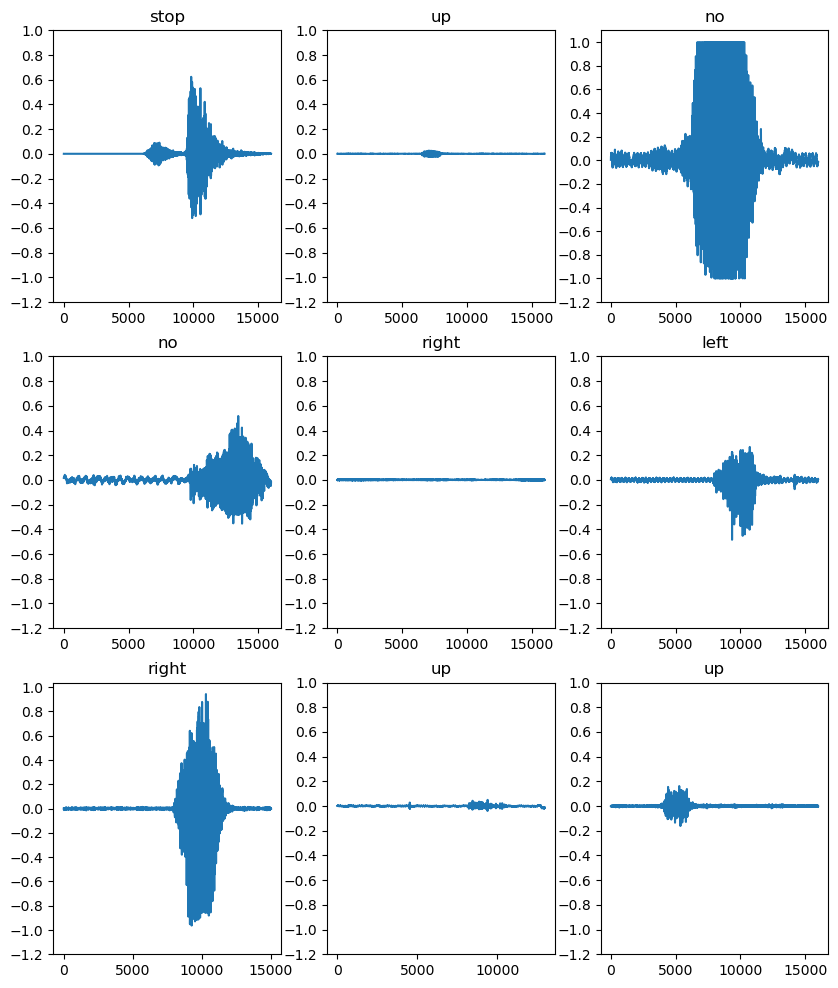

In [29]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
plt.show()

In [30]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

In [31]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


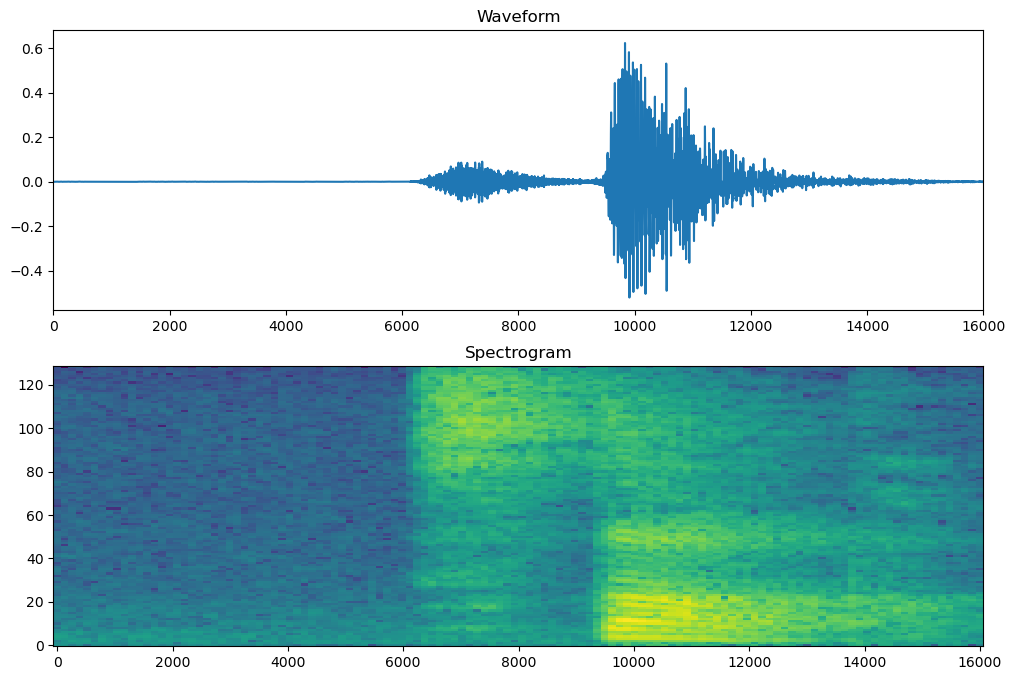

In [32]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns). An epsilon is added to avoid logof zero.
    log_spec = np.log(spectrogram.T+np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [33]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

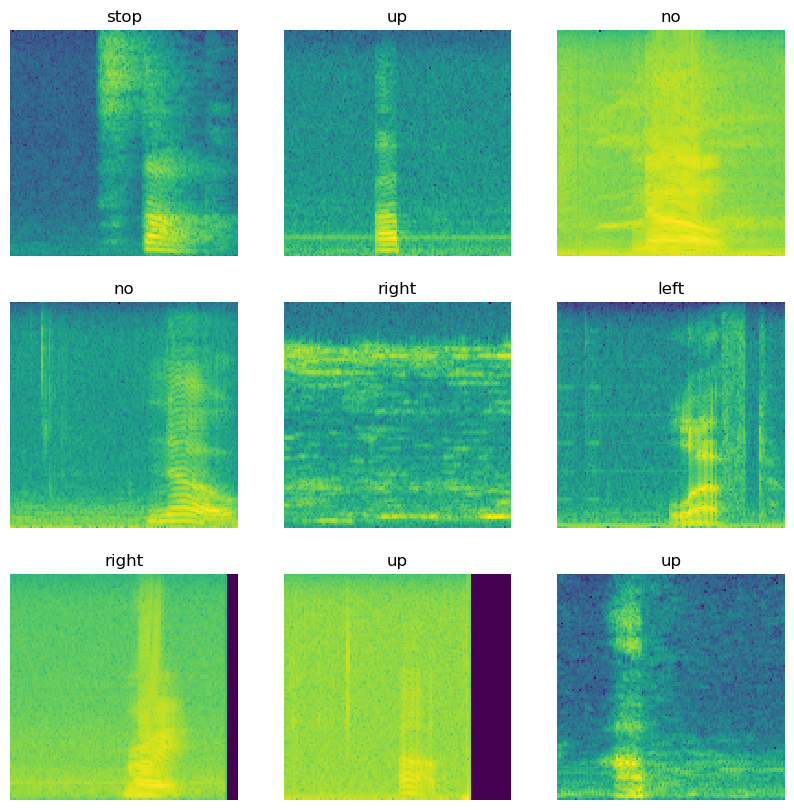

In [34]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')
plt.show()

In [57]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label,
num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
#print(test_ds)


In [58]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


In [59]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


In [60]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Input shape: (124, 129, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)       

In [61]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10
100/100 [==============================] - 24s 216ms/step - loss: 1.5522 - accuracy: 0.4359 - val_loss: 1.1199 - val_accuracy: 0.7222
Epoch 2/10
100/100 [==============================] - 14s 135ms/step - loss: 0.9912 - accuracy: 0.6681 - val_loss: 0.7829 - val_accuracy: 0.8056
Epoch 3/10
100/100 [==============================] - 14s 140ms/step - loss: 0.7314 - accuracy: 0.7591 - val_loss: 0.6118 - val_accuracy: 0.8611
Epoch 4/10
100/100 [==============================] - 14s 138ms/step - loss: 0.5665 - accuracy: 0.8108 - val_loss: 0.5900 - val_accuracy: 0.8611
Epoch 5/10
100/100 [==============================] - 13s 134ms/step - loss: 0.4823 - accuracy: 0.8311 - val_loss: 0.5204 - val_accuracy: 0.9167
Epoch 6/10
100/100 [==============================] - 14s 136ms/step - loss: 0.4278 - accuracy: 0.8517 - val_loss: 0.4537 - val_accuracy: 0.8889
Epoch 7/10
100/100 [==============================] - 13s 133ms/step - loss: 0.3705 - accuracy: 0.8709 - val_loss: 0.5098 - val_ac

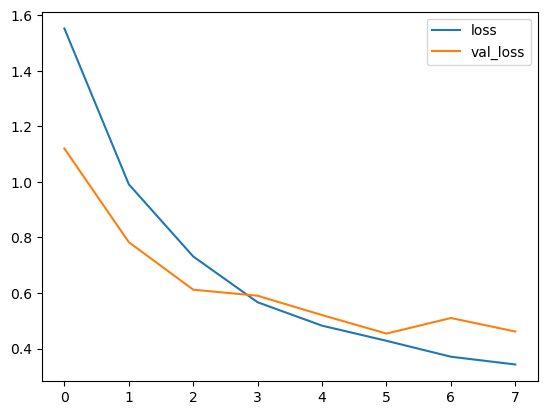

In [62]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [63]:
test_audio = []
test_labels = []
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
test_audio = np.array(test_audio)
#print(test_audio)
test_labels = np.array(test_labels)
#print(test_labels)
y_pred = np.argmax(model.predict(test_audio), axis=1)
#print(y_pred)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')


25/25 [==============================] - 1s 21ms/step
Test set accuracy: 94%


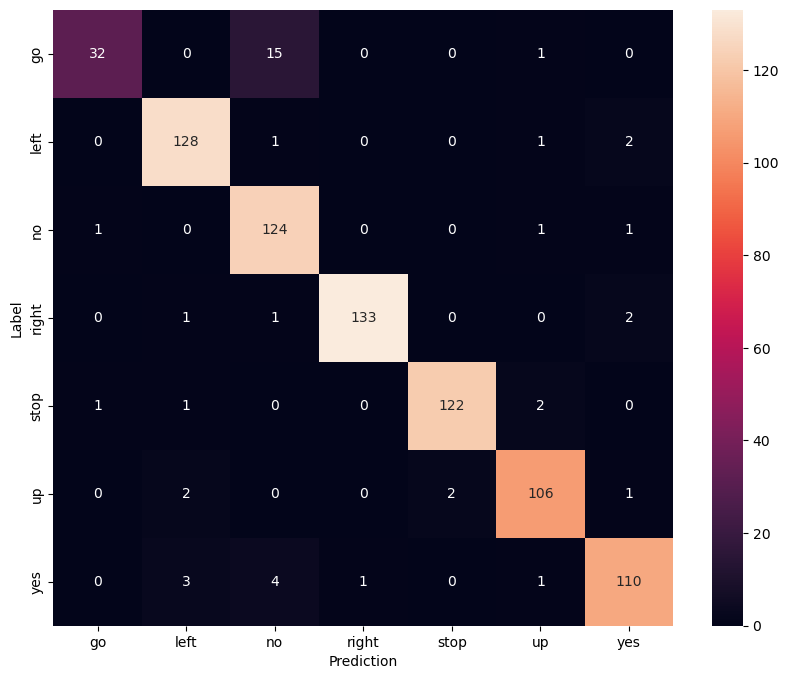

In [64]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

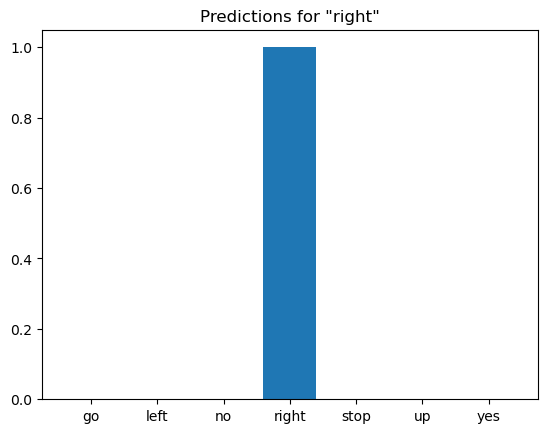

In [66]:
sample_file = data_dir/'right/ff63ab0b_nohash_0.wav' 
sample_ds = preprocess_dataset([str(sample_file)])
for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()